In this notebook the code is used to train the EHR-based model, CXR-based model fusion model inMadrid data. Hyper-parameters were tuned using a 4-fold cross validation approach. The results of 4-fold internal validation were also computed.

# Environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from tableone import TableOne
from scipy.stats import uniform, randint
from scipy.stats.mstats import winsorize
import seaborn as sns
# import shap
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score, brier_score_loss, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.externals import joblib
import os


seed = 2020

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pip install shap


     |████████████████████████████████| 358kB 28.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491618 sha256=a4206d6c3fa3efce9b78125b094335c5658876960868030df5bbeef1b789eed8
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load prediction from CXR-based model


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/covid19/predictions_cxr_model_4fold_models_predictions_v2.csv')
data

,Unnamed: 0,SOPInstanceUID,path,expired_30_days,patient_id,age,MALE,vitals_temp_ed_first,vitals_sbp_ed_first,vitals_dbp_ed_first,vitals_hr_ed_first,vitals_spo2_ed_first,pmhx_diabetes,pmhx_hld,pmhx_htn,pmhx_ihd,pmhx_ckd,pmhx_copd,pmhx_asthma,pmhx_activecancer,pmhx_chronicliver,pmhx_stroke,pmhx_chf,pmhx_dementia,lab_glucose,lab_creatinine,lab_mean_platelet_volume,lab_neutrophil,lab_mch,lab_prothrombin_activity,lab_ldh,lab_rbc,lab_rdw,lab_inr,lab_potassium,lab_aptt,lab_lymphocyte_percentage,lab_platelet,lab_mcv,lab_sodium,lab_urea,lab_hct,lab_lymphocyte,lab_leukocyte,lab_alt,lab_ast,lab_ddimer,lab_neutrophil_percentage,lab_crp,lab_hemoglobin,APview,bbox_coordinates,fold,predicted_probability
0,304,1.3.51.0.7.181565542.25952.64328.34017.44892.5...,gs://new_cxr_30/classified/ALIVE/test_1.3.51.0...,0,738.0,-1.500000,1.0,0.666667,0.000000,0.000,-1.058824,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406114,-0.740741,-0.4,-0.731801,-1.3125,1.428571,0.434024,1.016949,-1.9375,-1.142857,0.187500,11.428571,0.527059,-0.4500,-0.913043,0.735294,0.154321,0.673684,-0.169811,-0.793133,4.534202,4.938023,0.000000,-0.563910,-0.454840,0.470588,1,"[135, 29, 178, 164, 11, 50, 298, 303]",0,0.001093
1,39,1.3.12.2.1107.5.3.56.2693.11.202003271231300687,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,1026.0,-0.916667,1.0,0.833333,-0.266667,0.000,0.176471,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.179039,-0.888889,0.8,-0.157088,0.8125,0.142857,1.352781,-0.983051,-0.6250,-0.285714,-0.291667,4.190476,-0.357647,-0.2250,-0.065217,-0.352941,-0.740741,-1.073684,-0.358491,-0.315880,0.084691,0.804020,-0.293578,0.578947,1.434851,0.058824,1,"[120, 34, 162, 148, 9, 46, 288, 238]",0,0.072350
2,341,1.3.51.0.7.3412060171.33033.63557.36001.21862....,gs://new_cxr_30/classified/ALIVE/test_1.3.51.0...,0,2433.0,0.458333,1.0,0.000000,-2.733333,-1.000,-1.529412,1.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.039301,2.481481,0.0,0.842912,-1.4375,3.714286,-0.412759,0.152542,0.0000,-2.857143,-0.562500,7.238095,-0.847059,-1.1000,-1.434783,-0.088235,5.728395,-0.463158,-0.716981,0.563090,0.000000,0.000000,-0.988003,0.812030,-0.587801,-0.411765,1,"[135, 29, 178, 166, 39, 58, 294, 283]",0,0.217508
3,218,1.3.51.0.7.12213814209.18309.19527.45079.23149...,gs://new_cxr_30/classified/ALIVE/test_1.3.51.0...,0,2469.0,-0.375000,1.0,0.000000,0.000000,0.000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.921397,0.370370,-0.2,-0.233716,2.6875,3.000000,-1.274264,-1.186441,-0.6875,-2.142857,0.645833,-4.000000,1.101176,0.0500,2.869565,2.029412,-0.117284,-0.084211,1.716981,0.082403,-0.182410,-0.951424,-1.013409,-0.992481,-0.830622,0.117647,1,"[152, 29, 187, 163, 42, 71, 312, 266]",0,0.073332
4,155,1.3.46.670589.30.36.0.1.18774111139.1586155491...,gs://new_cxr_30/classified/ALIVE/test_1.3.46.6...,0,1117.0,0.291667,0.0,-1.500000,1.333333,1.500,0.117647,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.135371,0.185185,-0.2,-0.038314,-0.6875,-5.142857,0.281897,-2.593220,2.9375,9.142857,1.458333,2.857143,1.289412,3.7750,-0.086957,0.647059,1.975309,-2.842105,2.226415,0.230043,-0.312704,-0.067002,-0.115737,-0.729323,-0.520294,-2.823529,1,"[169, 29, 204, 157, 49, 66, 272, 241]",0,0.708583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,1095,1.3.51.0.7.721158296.24911.52300.35736.39303.3...,gs://new_cxr_30/classified/ALIVE/train_1.3.51....,0,1032.0,-0.416667,1.0,0.000000,1.200000,2.750,0.294118,-1.50,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,"[127, 29, 165, 157, 29, 64, 284, 233]",3,0.176722
1846,1130,1.3.76.6.1.1.5.2.3461.4.43917066947022043,gs://new_

Remove unnecessary columns

In [ ]:
data_drop = data.drop(columns=['Unnamed: 0', 'SOPInstanceUID','path','APview','bbox_coordinates',])
data_drop = data_drop.set_index('patient_id')
data_drop = data_drop.sort_index()

## Model Selection Function Definition 

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, make_scorer

def clipped_auc_scorer(y_true,y_pred):
    """
    Calculates the AUROC score, but returns 0 if sensitivity of the positive class is < 0.7
    """
    auc_score = roc_auc_score(y_true, y_pred)
    if recall_score(y_true,y_pred) >= 0.7:
        return auc_score
    else:
        return 0

clipped_auc = make_scorer(clipped_auc_scorer)

In [ ]:
def model_selection(summary_dict,model_lst,param_dict,
                    x_train,y_train,x_test,y_test,
                    n_iter=None,k_fold=None,n_repeats=None):
    """
    A wrapper function for the model selection loop
    
    Parameters
    ----------
    summary_dict: dict
        An empty dictionary used to store results.
    model_lst: list
        A list of tuples containing ('model_name',model), models are sklearn estimators
    param_dict: dict
        A dictionary containing model parameter distributions - to be passed to RandomizedSearchCV
    x_train: array-like
        An array training set predictors
    y_train: array-like
        An array containing training set labels
    x_test: array-like
        An array containing test set predictors
    y_test: array-like
        An array containing test set labels
    n_iter: int
        Number of crossvalidation iterations - to be passed to RandomizedSearchCV. Defaults to n_iter parameter at top of script
    k_fold: int
        Number of crossvalidation folds - to be passed to RandomizedSearchCV. Defaults to k_fold parameter at top of script
    n_repeats: int
        Number of crossvalidation repeats - to be passed to RandomizedSearchCV. Defaults to n_repeats parameter at top of script
        
    Returns
    -------
    summary_dict: pandas.DataFrame
        A dataframe containing the best model object and associated crossvalidation results
    result_table: pandas.DataFrame
        A dataframe containing all model objects and associated crossvalidation results
    """
    iterations = n_iter
    
    #Full list of scoring metrics
    scoring = {'roc_auc':'roc_auc',
               'average_precision':'average_precision',
               'accuracy': 'accuracy',
               'f1_macro':'f1_macro',
               'clipped_auc':clipped_auc}

    #Create an empty list used to store the results
    result_list = []

    #Loop through the list of models
    for name, model in model_lst:
        #Define the cross-validation folds
        cv = RepeatedStratifiedKFold(n_splits=k_fold,n_repeats=n_repeats)
        
        #Set the optimizing metric
        #refit_score = 'clipped_auc'
        refit_score = 'f1_macro'

        
        
        #Set the estimator as the model currently being optimized
        estimator = model
        
        for sample_weight_method in ['unbalanced','balanced']:
            for method in ['sigmoid','none']:
                #Wrap the model into calibration loop
                if method != 'none':
                    clf = CalibratedClassifierCV(estimator,method=method)
                    params = param_dict
                else:
                    clf= estimator
                    new_dict = {}
                    for key in param_dict.keys():
                        subdict = {}
                        for nested_key in param_dict[key].keys():
                            new_key_name = nested_key.split('base_estimator__')[1]
                            subdict[new_key_name] = param_dict[key][nested_key]
                        new_dict[key] = subdict
                    params = new_dict

                #Create the RandomizedSearchCV object
                search = RandomizedSearchCV(clf,param_distributions=params.get(name),random_state=seed,cv=cv,n_iter=iterations,n_jobs=-1,
                                        scoring=scoring,refit=refit_score,verbose=False,return_train_score=False)

                #Begin the grid search process
                if sample_weight_method == 'balanced':
                    search.fit(x_train, y_train, sample_weight=weight_array) 
                else:
                    search.fit(x_train, y_train) 

                #Calculate some metrics on the full training dataset (purely for diagnostics)
                y_pred = search.best_estimator_.predict(x_train)

                print(f'Algorithm: {name}')
                print(f'Calibration method: {method}')
                print(f'Sample weight method: {sample_weight_method}')
                print(classification_report(y_true=y_train,y_pred=y_pred))
                print(f'CV score ({refit_score}): {search.best_score_}')
                print()
            
                #Append the results of the best model to results_list
                result_list.append((name+'_'+method+'_'+sample_weight_method,search,search.best_score_,search.cv_results_))

        ##End of loop
    
    #The following code tidies result_list in to a dataframe
    result_table = pd.DataFrame(result_list,columns=['name','model','scores','score_dict'])
    best_model_index = result_table['scores']==max(result_table['scores'])
    model_name = result_table['name'][best_model_index].values.tolist()[0]
    best_model = result_table['model'][best_model_index].values.tolist()[0]
    summary_dict['results'] = {'Model':model_name}
    metrics = ['mean_test_roc_auc','mean_test_average_precision','mean_test_accuracy']
    if hasattr(best_model,'best_score_'):
        best_score = best_model.best_score_ 
        for key in [key for key in best_model.cv_results_.keys() if key in metrics]:
            summary_dict['results'][key.split('mean_test_')[1]] = best_model.cv_results_[key][best_model.best_index_]
        summary_dict['results']['model obj'] = best_model.best_estimator_
    else:
        best_score = mean_cv_roc_auc
        summary_dict['results']['model obj'] = best_model
        for key in [key for key in best_search.cv_results_.keys() if key in metrics]:
            summary_dict['results'][key.split('mean_test_')[1]] = result_table['score_dict'][best_model_index].get(key)
    
    #Find the overall results
    print(f"Best Cross-Validation score: {best_score}")        
    return summary_dict, result_table

## Train the final model 

In [ ]:
#This cell runs the model selection loop 
summary_dict = {}

#Create model objects
logistic = SGDClassifier(loss='log',random_state=seed)
rf = RandomForestClassifier(random_state=seed)
gbm = GradientBoostingClassifier(random_state=seed)
xgbclf = XGBClassifier(random_state=seed,objective='binary:logistic')

# classifier_list = [('xgb',xgbclf)] #,('gbm',gbm),('rf',rf),
classifier_list = [('xgb',xgbclf),('lr',logistic),('gbm',gbm),('rf',rf)]


#Calculate class weights
weight_array = compute_sample_weight(class_weight="balanced",y=y_train)

#Define the hyperparameter search space
params = {'lr':{'base_estimator__alpha':uniform(1e-5,1e-3),
                'base_estimator__penalty':['l1', 'l2', 'elasticnet'],
                'base_estimator__l1_ratio':uniform(0.01,0.30)},
          'rf':{'base_estimator__bootstrap': [True, False],
                'base_estimator__max_depth':randint(3,12),
                'base_estimator__max_features': ['auto', 'sqrt'],
                'base_estimator__min_samples_split':randint(2,12),
                'base_estimator__min_samples_leaf':randint(2,12),
                'base_estimator__n_estimators':randint(200, 1000)},
          'gbm':{'base_estimator__loss':['deviance','exponential'],
                 'base_estimator__learning_rate':uniform(0.003, 0.3),
                 'base_estimator__n_estimators':randint(200, 1000),
                 'base_estimator__subsample':uniform(0.5, 0.5),
                 'base_estimator__criterion':['friedman_mse','mse','mae'],
                 'base_estimator__min_samples_split':randint(2,12),
                 'base_estimator__min_samples_leaf':randint(2,12),
                 'base_estimator__max_depth':randint(3,12),
                 'base_estimator__max_features':['sqrt', 'log2']},
          'xgb':{'base_estimator__colsample_bytree': uniform(0.1,1),
                 'base_estimator__eta': (0.0001,0.1),
                 'base_estimator__max_depth': randint(3,12),
                 'base_estimator__min_child_weight': randint(3,12),
                 'base_estimator__subsample': uniform(0.1,1)}}

#Run the model selection loop
summary_dict, results = model_selection(summary_dict=summary_dict,
                                        model_lst=classifier_list,
                                        param_dict=params,
                                        n_iter=50,k_fold=4,n_repeats=1)

NameError: ignored

In [ ]:
best_model_index = results['scores']==max(results['scores'])
best_params = results['model'][best_model_index].values.tolist()[0]
print(best_params)

NameError: ignored

In [ ]:
cv_results = results.sort_values('scores',ascending=False).reset_index(drop=True)
cv_results['model'][0]

In [ ]:
cv_results['model'][0].predict(x_train)

In [ ]:
# Train final model
Train_data = data_drop[(data_drop.index > 0)]
Test_data = data_drop[(data_drop.index > 0)]

In [ ]:
# x_test = Test_data.drop(columns=['expired_30_days', 'fold', 'predicted_probability'])   # for EHR-based model 
x_test = Test_data.drop(columns=['expired_30_days', 'fold']) # for fusion model 
y_test = Test_data['expired_30_days']
male_test = Test_data['MALE']
# x_train = Train_data.drop(columns=['expired_30_days', 'fold', 'predicted_probability']) # for EHR-based model 
x_train = Train_data.drop(columns=['expired_30_days', 'fold']) # for fusion model 
y_train = Train_data['expired_30_days']

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
list(x_test.columns)

# Feature importance

In [ ]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.KernelExplainer(cv_results['model'][0].predict,data=x_train)
shap_values = explainer.shap_values(x_train)


# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

Provided model function fails when applied to the provided data set.


ValueError: ignored

In [ ]:
x_train_new = x_train.rename(columns={'predicted_probability': 'CXR_prediction'})
shap.summary_plot(shap_values, x_train_new)

#Save model

In [ ]:
clf_list = list(zip(cv_results['name'].iloc[0:4],cv_results['model'].iloc[0:4]))

# Save the best 4 estimaters
model_path = './gdrive/My Drive/covid19/models/'
if not os.path.isdir(model_path):
    os.mkdir(model_path)

count = 1

for name,best_model in clf_list:
    best_model = best_model.best_estimator_
    y_score = best_model.predict_proba(x_test)[:,1]
    average_precision = average_precision_score(y_test, y_score)
    disp = plot_precision_recall_curve(best_model, x_test, y_test)
    disp.ax_.set_title(f'{name} 2-class Precision-Recall curve: '
                    'AP={0:0.2f}'.format(average_precision))
    # joblib.dump(best_model, os.path.join(model_path,name+'_bestf1_'+str(count)+'_fold' + str(fold_num) + '.pkl'), compress = 1)
    # joblib.dump(best_model, os.path.join(model_path,name+'_EHR_model_bestf1_fold' + str(fold_num) + '.pkl'), compress = 1)
    # joblib.dump(best_model, os.path.join(model_path,name+'_EHR_model_bestf1'+str(count)+'.pkl'), compress = 1)
    joblib.dump(best_model, os.path.join(model_path,name+'_fusion_model_bestf1'+str(count)+'.pkl'), compress = 1)
    count = count + 1

NameError: ignored

#Internal cross validation

In [ ]:
fuse = True

In [ ]:
for fold_num in range(4):
  print(fold_num)
  Test_data = data_drop[(data_drop.fold == fold_num) & (data_drop.index > 0)]
  Train_data = data_drop[(data_drop.fold != fold_num) & (data_drop.index > 0)]

  if (fuse):
    x_test = Test_data.drop(columns=['expired_30_days', 'fold']) # for fusion model 
    x_train = Train_data.drop(columns=['expired_30_days', 'fold']) # for fusion model 
  else:
    x_test = Test_data.drop(columns=['expired_30_days', 'fold', 'predicted_probability'])   # for EHR-based model 
    x_train = Train_data.drop(columns=['expired_30_days', 'fold', 'predicted_probability']) # for EHR-based model 

  y_test = Test_data['expired_30_days']
  male_test = Test_data['MALE']
  y_train = Train_data['expired_30_days']

  #This cell runs the model selection loop 
  summary_dict = {}

  #Create model objects
  logistic = SGDClassifier(loss='log',random_state=seed)
  rf = RandomForestClassifier(random_state=seed)
  gbm = GradientBoostingClassifier(random_state=seed)
  xgbclf = XGBClassifier(random_state=seed,objective='binary:logistic')

  # classifier_list = [('xgb',xgbclf)] 
  classifier_list = [('xgb',xgbclf),('lr',logistic) ,('gbm',gbm),('rf',rf) ] 

  #Calculate class weights
  weight_array = compute_sample_weight(class_weight="balanced",y=y_train)

  #Define the hyperparameter search space
  params = {'lr':{'base_estimator__alpha':uniform(1e-5,1e-3),
                  'base_estimator__penalty':['l1', 'l2', 'elasticnet'],
                  'base_estimator__l1_ratio':uniform(0.01,0.30)},
            'rf':{'base_estimator__bootstrap': [True, False],
                  'base_estimator__max_depth':randint(3,12),
                  'base_estimator__max_features': ['auto', 'sqrt'],
                  'base_estimator__min_samples_split':randint(2,12),
                  'base_estimator__min_samples_leaf':randint(2,12),
                  'base_estimator__n_estimators':randint(200, 1000)},
            'gbm':{'base_estimator__loss':['deviance','exponential'],
                  'base_estimator__learning_rate':uniform(0.003, 0.3),
                  'base_estimator__n_estimators':randint(200, 1000),
                  'base_estimator__subsample':uniform(0.5, 0.5),
                  'base_estimator__criterion':['friedman_mse','mse','mae'],
                  'base_estimator__min_samples_split':randint(2,12),
                  'base_estimator__min_samples_leaf':randint(2,12),
                  'base_estimator__max_depth':randint(3,12),
                  'base_estimator__max_features':['sqrt', 'log2']},
            'xgb':{'base_estimator__colsample_bytree': uniform(0.1,1),
                  'base_estimator__eta': (0.0001,0.1),
                  'base_estimator__max_depth': randint(3,12),
                  'base_estimator__min_child_weight': randint(3,12),
                  'base_estimator__subsample': uniform(0.1,1)}}

  #Run the model selection loop
  summary_dict, results = model_selection(x_train=x_train,y_train=y_train, x_test=x_test,y_test=y_test, summary_dict=summary_dict,
                                          model_lst=classifier_list,
                                          param_dict=params,
                                          n_iter=50,k_fold=4,n_repeats=1)
  best_model_index = results['scores']==max(results['scores'])
  best_params = results['model'][best_model_index].values.tolist()[0]
  print(best_params)
  cv_results = results.sort_values('scores',ascending=False).reset_index(drop=True)
  # cv_results = results.sort_values('scores',ascending=False)
  clf_list = list(zip(cv_results['name'].iloc[0:4],cv_results['model'].iloc[0:4]))
  
  model_path = './gdrive/My Drive/covid19/models/'
  if not os.path.isdir(model_path):
      os.mkdir(model_path)

  rank = 1
  for name,best_model in clf_list:
      best_model = best_model.best_estimator_
      if (fuse):
        joblib.dump(best_model, os.path.join(model_path,name+'_fusion_model_bestf1_ver2_'+ str(rank)+'fold' + str(fold_num) +  '.pkl'), compress = 1)
      else:
        joblib.dump(best_model, os.path.join(model_path,name+'_EHR_model_bestf1_ver2_'+ str(rank)+'fold' + str(fold_num) +  '.pkl'), compress = 1)
      rank = rank + 1

0
Algorithm: xgb
Calibration method: sigmoid
Sample weight method: unbalanced
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1076
           1       0.74      0.31      0.44       138

    accuracy                           0.91      1214
   macro avg       0.83      0.65      0.69      1214
weighted avg       0.90      0.91      0.89      1214

CV score (f1_macro): 0.6529995072004855

Algorithm: xgb
Calibration method: none
Sample weight method: unbalanced
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1076
           1       1.00      0.60      0.75       138

    accuracy                           0.95      1214
   macro avg       0.98      0.80      0.86      1214
weighted avg       0.96      0.95      0.95      1214

CV score (f1_macro): 0.6712102475754348

Algorithm: xgb
Calibration method: sigmoid
Sample weight method: balanced
              precision    recall  f1-s

#Compute final result

In [ ]:
import glob
model_path = './gdrive/My Drive/covid19/models/'
#reading back in

for fold_num in range(4):
  print(fold_num)
  if(fuse):
   fpath = glob.glob(model_path+'*fusion_model_bestf1_2fold'+str(fold_num)+'.pkl')    
  else:
    fpath = glob.glob(model_path+'*EHR_model_bestf1_ver2_1fold'+str(fold_num)+'.pkl') 
  clf = joblib.load(fpath[0]) 

  Test_data = data_drop[(data_drop.fold == fold_num) & (data_drop.index > 0)]
  y_test = Test_data['expired_30_days']

  if (fuse):
    x_test = Test_data.drop(columns=['expired_30_days', 'fold']) # for fusion model 
  else:
    x_test = Test_data.drop(columns=['expired_30_days', 'fold', 'predicted_probability'])   # for EHR-based model 

  male_test = Test_data['MALE']

  ypred = clf.predict(x_test)
  y_prob = clf.predict_proba(x_test)
  #print(classification_report(y_true=y_test,y_pred=ypred))
  print(clf.score)

  if (fold_num == 0):
    y_test_0 = y_test.copy()
    ypred_0 = ypred.copy()
    y_prob_0 = y_prob.copy()
    male_test_0 = male_test.copy()
  if (fold_num == 1):
    y_test_1 = y_test.copy()
    ypred_1 = ypred.copy()
    y_prob_1 = y_prob.copy()
    male_test_1 = male_test.copy()
  if (fold_num == 2):
    y_test_2 = y_test.copy()
    ypred_2 = ypred.copy()
    y_prob_2 = y_prob.copy()
    male_test_2 = male_test.copy()
  if (fold_num == 3):
    y_test_3 = y_test.copy()
    ypred_3 = ypred.copy()
    y_prob_3 = y_prob.copy() 
    male_test_3 = male_test.copy()

0
<bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.14298561927565448, eta=0.1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.26970243840241936, verbosity=1)>
1
<bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5289953965873598,
              eta=0.0001, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=5, missing=nan, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=2020, reg_alpha=

In [ ]:
y_test_c = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)
ypred_c = np.concatenate((ypred_0, ypred_1, ypred_2, ypred_3), axis=0)
y_prob_c = np.concatenate((y_prob_0, y_prob_1, y_prob_2, y_prob_3), axis=0)
male_test = np.concatenate((male_test_0, male_test_1, male_test_2, male_test_3), axis=0)
print(y_test_c.shape)
prob = y_prob_c[:,1]


(1628,)


#Save the prediction results

In [ ]:
# # np.savetxt("./gdrive/My Drive/covid19/f1_y_test_c_fuse.csv", y_test_c, delimiter=",")
# # np.savetxt("./gdrive/My Drive/covid19/f1_ypred_c_fuse.csv", ypred_c, delimiter=",")
# # np.savetxt("./gdrive/My Drive/covid19/f1_y_prob_c_fuse.csv", y_prob_c, delimiter=",")

# np.savetxt("./gdrive/My Drive/covid19/f1_y_test_c_str_only.csv", y_test_c, delimiter=",")
# np.savetxt("./gdrive/My Drive/covid19/f1_ypred_c_str_only.csv", ypred_c, delimiter=",")
# np.savetxt("./gdrive/My Drive/covid19/f1_y_prob_c_str_only.csv", y_prob_c, delimiter=",")

In [ ]:
# from numpy import genfromtxt

# # y_test_c = genfromtxt("./gdrive/My Drive/covid19/f1_y_test_c_fuse.csv", delimiter=',')
# # ypred_c = genfromtxt("./gdrive/My Drive/covid19/f1_ypred_c_fuse.csv", delimiter=',')
# # y_prob_c = genfromtxt("./gdrive/My Drive/covid19/f1_y_prob_c_fuse.csv", delimiter=',')

# y_test_c = genfromtxt("./gdrive/My Drive/covid19/f1_y_test_c_str_only.csv", delimiter=',')
# ypred_c = genfromtxt("./gdrive/My Drive/covid19/f1_ypred_c_str_only.csv", delimiter=',')
# y_prob_c = genfromtxt("./gdrive/My Drive/covid19/f1_y_prob_c_str_only.csv", delimiter=',')

# prob = y_prob_c[:,1]


#Fairness analysis

In [ ]:
# prob = prob[male_test==1]
# y_test_c = y_test_c[male_test==1]
# # data_drop = data_drop[data_drop['MALE'] == 1]
# print(len(prob))

980


#Draw ROC curve for CXR-based model


In [ ]:
# Test_data_all = data_drop[(data_drop.index > 0)]
# prob=Test_data_all['predicted_probability']
# y_test_c = Test_data_all['expired_30_days']

# y_test_c = y_test_c.to_numpy()
# prob = prob.to_numpy()
# print(y_test_c.shape)

#Draw ROC curve for EHR-based and fusion model 



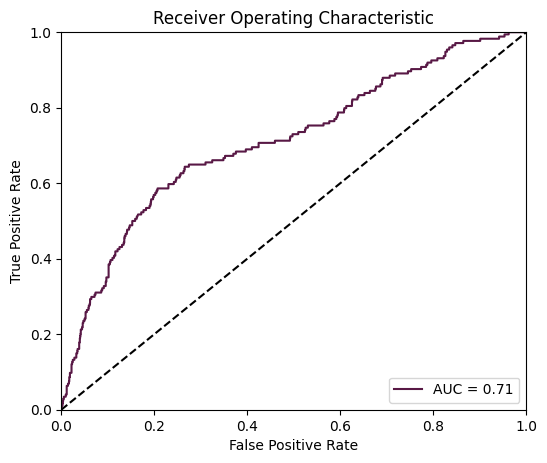

In [ ]:
plt.figure(figsize=(6,5),dpi=100)
plt.title('Receiver Operating Characteristic')

color_list = ['#581845','#900C3F','#C70039','#FF5733']
col = 0

from sklearn import metrics


fpr, tpr, threshold = roc_curve(y_test_c, prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color_list[col], label = f'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
col += 1
plt.savefig("output.svg")
plt.show();


In [ ]:
import sklearn.metrics

fpr, tpr, thresholds = roc_curve(y_test_c, prob)
optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
optimal_threshold = thresholds[optimal_idx]

## use optimal cut-point 
predicted_class = np.zeros(len(prob), dtype=int)
predicted_class[prob < optimal_threshold] = 0
predicted_class[prob >= optimal_threshold] = 1

## use 0.5 as cut-point 
# predicted_class[predictions < 0.5] = 0
# predicted_class[predictions >= 0.5] = 1
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()

# use softmax
# predicted_class = np.around(predictions).astype(int)
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()


tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_c, predicted_class).ravel()
roc_auc = sklearn.metrics.roc_auc_score(y_test_c, prob)
sensitivity = tp / (tp + fn) # recall
specificity = tn / (tn + fp)
PPV = tp / (tp + fp) #precision
NPV = tn / (tn + fn) #NPV
f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
acc = (tp + tn) / (tn + fp + fn + tp)

print(f'AUROC: {roc_auc:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'PPV: {PPV:.2f}')
print(f'NPV: {NPV:.2f}')    
print(f'F1-score: {f1:.2f}')
print(f'Accuracy: {acc:.2f}')
print(f'tn, fp, fn, tp: {tn, fp, fn, tp}')

AUROC: 0.71
Sensitivity: 0.64
Specificity: 0.73
PPV: 0.22
NPV: 0.95
F1-score: 0.33
Accuracy: 0.72
tn, fp, fn, tp: (1068, 386, 62, 112)


In [ ]:
import statistics

n_bootstraps = 1000
rng_seed = 47  # control reproducibility
bootstrapped_auc = []
bootstrapped_specificity = []
bootstrapped_sensitivity = []
bootstrapped_PPV = []
bootstrapped_NPV = []
bootstrapped_f1 = []
bootstrapped_acc = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(prob), len(prob))
    while len(np.unique(y_test_c[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        indices = rng.randint(0, len(prob), len(prob))


    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_c[indices], prob[indices])
    optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
    optimal_threshold = thresholds[optimal_idx]
    predicted_class = np.zeros(len(prob))
    predicted_class[prob > optimal_threshold] = 1
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_c[indices], predicted_class[indices]).ravel()

    auc = sklearn.metrics.roc_auc_score(y_test_c[indices], prob[indices])
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn) # recall
    PPV = tp / (tp + fp) #precision
    NPV = tn / (tn + fn) #NPV
    # f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
    f1 = sklearn.metrics.f1_score(y_test_c[indices], predicted_class[indices])
    acc = (tp + tn) / (tn + fp + fn + tp)

    bootstrapped_auc.append(auc)
    bootstrapped_specificity.append(specificity)
    bootstrapped_sensitivity.append(sensitivity)
    bootstrapped_PPV.append(PPV)
    bootstrapped_NPV.append(NPV)
    bootstrapped_f1.append(f1)
    bootstrapped_acc.append(acc)

print("AUROC: {:0.4f} +- {:0.4f}".format(statistics.mean(bootstrapped_auc), statistics.stdev(bootstrapped_auc)))      
print("Sensitivity(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_sensitivity)*100, statistics.stdev(bootstrapped_sensitivity)*100))
print("Specificity(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_specificity)*100, statistics.stdev(bootstrapped_specificity)*100)) 
print("PPV(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_PPV)*100, statistics.stdev(bootstrapped_PPV)*100))
print("NPV(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_NPV)*100, statistics.stdev(bootstrapped_NPV)*100))
print("f1-score: {:0.4f} +- {:0.4f}".format(statistics.mean(bootstrapped_f1), statistics.stdev(bootstrapped_f1)))
print("Accuracy(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_acc)*100, statistics.stdev(bootstrapped_acc)*100))


sorted_auc = np.array(bootstrapped_auc)
sorted_auc.sort()
confidence_lower_auc = sorted_auc[int(0.05 * len(sorted_auc))]
confidence_upper_auc = sorted_auc[int(0.95 * len(sorted_auc))]

sorted_sen = np.array(bootstrapped_sensitivity)
sorted_sen.sort()
confidence_lower_sen = sorted_sen[int(0.05 * len(sorted_sen))]
confidence_upper_sen = sorted_sen[int(0.95 * len(sorted_sen))]

sorted_spe = np.array(bootstrapped_specificity)
sorted_spe.sort()
confidence_lower_spe = sorted_spe[int(0.05 * len(sorted_spe))]
confidence_upper_spe = sorted_spe[int(0.95 * len(sorted_spe))]

sorted_ppv = np.array(bootstrapped_PPV)
sorted_ppv.sort()
confidence_lower_ppv = sorted_ppv[int(0.05 * len(sorted_ppv))]
confidence_upper_ppv = sorted_ppv[int(0.95 * len(sorted_ppv))]

sorted_npv = np.array(bootstrapped_NPV)
sorted_npv.sort()
confidence_lower_npv = sorted_npv[int(0.05 * len(sorted_npv))]
confidence_upper_npv = sorted_npv[int(0.95 * len(sorted_npv))]

sorted_f1 = np.array(bootstrapped_f1)
sorted_f1.sort()
confidence_lower_f1 = sorted_f1[int(0.05 * len(sorted_f1))]
confidence_upper_f1 = sorted_f1[int(0.95 * len(sorted_f1))]

sorted_acc = np.array(bootstrapped_acc)
sorted_acc.sort()
confidence_lower_acc = sorted_acc[int(0.05 * len(sorted_acc))]
confidence_upper_acc = sorted_acc[int(0.95 * len(sorted_acc))]


print("Confidence interval for the auc: [{:0.2f}-{:0.2}]".format(confidence_lower_auc, confidence_upper_auc))     
print("Confidence interval for the sen: [{:0.2f}-{:0.2}]".format(confidence_lower_sen, confidence_upper_sen))
print("Confidence interval for the spe: [{:0.2f}-{:0.2}]".format(confidence_lower_spe, confidence_upper_spe))
print("Confidence interval for the ppv: [{:0.2f}-{:0.2}]".format(confidence_lower_ppv, confidence_upper_ppv))
print("Confidence interval for the npv: [{:0.2f}-{:0.2}]".format(confidence_lower_npv, confidence_upper_npv))
print("Confidence interval for the f1: [{:0.2f}-{:0.2}]".format(confidence_lower_f1, confidence_upper_f1))
print("Confidence interval for the acc: [{:0.2f}-{:0.2}]".format(confidence_lower_acc, confidence_upper_acc))

AUROC: 0.7123 +- 0.0221
Sensitivity(%): 63.42 +- 3.64
Specificity(%): 74.08 +- 2.34
PPV(%): 22.75 +- 2.35
NPV(%): 94.42 +- 0.67
f1-score: 0.3341 +- 0.0268
Accuracy(%): 72.94 +- 2.04
Confidence interval for the auc: [0.68-0.75]
Confidence interval for the sen: [0.57-0.69]
Confidence interval for the spe: [0.71-0.8]
Confidence interval for the ppv: [0.19-0.27]
Confidence interval for the npv: [0.93-0.96]
Confidence interval for the f1: [0.29-0.38]
Confidence interval for the acc: [0.70-0.77]
